<a href="https://colab.research.google.com/github/CoaDiego/SIS420---IA/blob/main/1erParcial/1erparcial_coavelizdiegoarmando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

La escala Fujita Enhance

Clasificación	/ Velocidad del viento	/ Daño

EF0	/ 65–85 mph	  / Daños leves

EF1	/ 86–110 mph	/ Daño moderado

EF2	/ 111–135 mph	/ Daños considerables

EF3	/ 136–165 mph	/ Daños graves

EF4	/ 166–200 mph	/ Daños devastadores


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

import pandas as pd
# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

Pre - Procesamiento de Datos

In [ ]:
# Leer el archivo CSV
datos_ds = pd.read_csv('/content/drive/Othercomputers/Mi PC/Semestre 2-2024/SIS420 - INTELIGENCIA ARTIFICIAL I/SIS420---IA/1erParcial/96.US Tornado Dataset 1950-2021/us_tornado_dataset_1950_2021.csv')

# Convertir la columna 'date' a datetime
datos_ds['date'] = pd.to_datetime(datos_ds['date'])

# Extraer mes y día (sin extraer el año)
datos_ds['month'] = datos_ds['date'].dt.month
datos_ds['day'] = datos_ds['date'].dt.day

# Verifica las primeras filas para ver si los días se están asignando correctamente
print(datos_ds[['date', 'day', 'month']].head())

# Eliminar la columna 'date'
datos_ds = datos_ds.drop(columns=['date'])

#Mostrar el DataFrame para verificar que 'mag' está al final
print("DataFrame con la columna 'mag' al final:")
print(datos_ds.head())

#Mostrar el DataFrame para verificar
print("DataFrame con componentes de fecha extraídos:")
print(datos_ds.head())


        date  day  month
0 1950-01-03    3      1
1 1950-01-03    3      1
2 1950-01-03    3      1
3 1950-01-13   13      1
4 1950-01-25   25      1
DataFrame con la columna 'mag' al final:
     yr  mo  dy  st  mag  inj  fat   slat   slon   elat   elon  len  wid  \
0  1950   1   3  IL    3    3    0  39.10 -89.30  39.12 -89.23  3.6  130   
1  1950   1   3  MO    3    3    0  38.77 -90.22  38.83 -90.03  9.5  150   
2  1950   1   3  OH    1    1    0  40.88 -84.58   0.00   0.00  0.1   10   
3  1950   1  13  AR    3    1    1  34.40 -94.37   0.00   0.00  0.6   17   
4  1950   1  25  IL    2    0    0  41.17 -87.33   0.00   0.00  0.1  100   

   month  day  
0      1    3  
1      1    3  
2      1    3  
3      1   13  
4      1   25  
DataFrame con componentes de fecha extraídos:
     yr  mo  dy  st  mag  inj  fat   slat   slon   elat   elon  len  wid  \
0  1950   1   3  IL    3    3    0  39.10 -89.30  39.12 -89.23  3.6  130   
1  1950   1   3  MO    3    3    0  38.77 -90.22  38.83 -9

In [ ]:
print(datos_ds.columns)
# Verifica los valores originales de la columna 'mag'
print(datos_ds['mag'].head(10))

Index(['yr', 'mo', 'dy', 'st', 'mag', 'inj', 'fat', 'slat', 'slon', 'elat',
       'elon', 'len', 'wid', 'month', 'day'],
      dtype='object')
0    3
1    3
2    1
3    3
4    2
5    2
6    2
7    2
8    2
9    2
Name: mag, dtype: int64


1.      Inserte atributos que contengan, caracteres, texto, valores booleanos relacionados a la temática del dataset elegido

In [ ]:
# Agregar nuevas columnas:
# 1. Columna de texto: Tipo de tornado
datos_ds['tipo_tornado'] = ['A' if mag in [1, 2] else 'B' if mag in [3, 4] else 'C' for mag in datos_ds['mag']]

#2 Crear una columna booleana 'victimas_M' donde 1 indica víctimas mortales y 0 indica ninguna
datos_ds['victimas_M'] = datos_ds['fat'].apply(lambda x: 1 if x > 0 else 0)

# Mover la nueva columna 'victimas_M' al final
columna_victimas = datos_ds.pop('victimas_M')
datos_ds['victimas_M'] = columna_victimas

# 3.Definir una función para categorizar la longitud del tornado
def categorizar_longitud(longitud):
    if longitud < 1:
        return 'diminuto'
    elif 1 <= longitud < 5:
        return 'pequeño'
    else:
        return 'grande'

# Aplicar la función para crear la columna 'tamaño_torn'
datos_ds['tamaño_torn'] = datos_ds['len'].apply(categorizar_longitud)

# Mover la columna 'tamaño_torn' al final
columna_tamaño_torn = datos_ds.pop('tamaño_torn')
datos_ds['tamaño_torn'] = columna_tamaño_torn

# Mover la columna 'mag' al final del DataFrame
columna_mag = datos_ds.pop('mag')  # Extraer la columna 'mag'
datos_ds['mag'] = columna_mag      # Añadir la columna 'mag' al final

# Mostrar el DataFrame para verificar que la columna 'tamaño_torn' está correctamente añadida y ubicada
print(datos_ds.head())


     yr  mo  dy  st  inj  fat   slat   slon   elat   elon  len  wid  month  \
0  1950   1   3  IL    3    0  39.10 -89.30  39.12 -89.23  3.6  130      1   
1  1950   1   3  MO    3    0  38.77 -90.22  38.83 -90.03  9.5  150      1   
2  1950   1   3  OH    1    0  40.88 -84.58   0.00   0.00  0.1   10      1   
3  1950   1  13  AR    1    1  34.40 -94.37   0.00   0.00  0.6   17      1   
4  1950   1  25  IL    0    0  41.17 -87.33   0.00   0.00  0.1  100      1   

   day tipo_tornado  victimas_M tamaño_torn  mag  
0    3            B           0     pequeño    3  
1    3            B           0      grande    3  
2    3            A           0    diminuto    1  
3   13            B           1    diminuto    3  
4   25            A           0    diminuto    2  


Convertir las columnas de "st" , "tamaño_torn" y "tipo_tornado" a numerico

In [ ]:
# Convertir el DataFrame a un array de NumPy
#data = datos_ds.to_numpy()
# Ahora 'data' es un array de NumPy y puedes realizar operaciones con él

st a valor numerico

In [ ]:
# Supongamos que 'datos_ds' es tu DataFrame
# Verificar los valores únicos en la columna 'st'
valores_unicos_st = datos_ds['st'].unique()

# Mostrar los valores únicos
print(valores_unicos_st)


['IL' 'MO' 'OH' 'AR' 'TX' 'LA' 'MS' 'TN' 'OK' 'FL' 'AL' 'SC' 'KS' 'IA'
 'NE' 'SD' 'WY' 'NC' 'GA' 'ND' 'MN' 'WI' 'IN' 'PA' 'NM' 'CT' 'CO' 'WV'
 'MD' 'KY' 'CA' 'VA' 'NJ' 'MI' 'MA' 'NH' 'OR' 'NY' 'MT' 'AZ' 'UT' 'ME'
 'VT' 'ID' 'WA' 'DE' 'HI' 'PR' 'AK' 'NV' 'RI' 'DC' 'VI']


In [ ]:
# Crear un diccionario para mapear abreviaciones de estados a números
estado_a_numero = {estado: i for i, estado in enumerate(
    ['IL', 'MO', 'OH', 'AR', 'TX', 'LA', 'MS', 'TN', 'OK', 'FL', 'AL', 'SC',
     'KS', 'IA', 'NE', 'SD', 'WY', 'NC', 'GA', 'ND', 'MN', 'WI', 'IN', 'PA',
     'NM', 'CT', 'CO', 'WV', 'MD', 'KY', 'CA', 'VA', 'NJ', 'MI', 'MA', 'NH',
     'OR', 'NY', 'MT', 'AZ', 'UT', 'ME', 'VT', 'ID', 'WA', 'DE', 'HI', 'PR',
     'AK', 'NV', 'RI', 'DC', 'VI'])
}

# Convertir la columna 'st' a valores numéricos usando el diccionario de conversión
datos_ds['st'] = datos_ds['st'].map(estado_a_numero)

# Verificar los primeros valores para asegurarse de la conversión
print(datos_ds[['st']].head())


   st
0   0
1   1
2   2
3   3
4   0


In [213]:
# Verificar valores únicos en la columna 'st' después de la conversión
print(datos_ds['st'].unique())
print(datos_ds.head())


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
     yr  mo  dy  st  inj  fat   slat   slon   elat   elon  len  wid  month  \
0  1950   1   3   0    3    0  39.10 -89.30  39.12 -89.23  3.6  130      1   
1  1950   1   3   1    3    0  38.77 -90.22  38.83 -90.03  9.5  150      1   
2  1950   1   3   2    1    0  40.88 -84.58   0.00   0.00  0.1   10      1   
3  1950   1  13   3    1    1  34.40 -94.37   0.00   0.00  0.6   17      1   
4  1950   1  25   0    0    0  41.17 -87.33   0.00   0.00  0.1  100      1   

   day tipo_tornado  victimas_M tamaño_torn  mag  
0    3            B           0     pequeño    3  
1    3            B           0      grande    3  
2    3            A           0    diminuto    1  
3   13            B           1    diminuto    3  
4   25            A           0    diminuto    2  


In [214]:
# 2. Convertir la columna 'tamaño_torn' a numérico
# Crear un mapeo para las categorías
tamaño_torn_mapping = {'diminuto': 0, 'pequeño': 1, 'grande': 2}
datos_ds['tamaño_torn'] = datos_ds['tamaño_torn'].map(tamaño_torn_mapping)

# 3. Convertir la columna 'tipo_tornado' a numérico
# Crear un mapeo para las categorías
tipo_tornado_mapping = {'A': 0, 'B': 1, 'C': 2}
datos_ds['tipo_tornado'] = datos_ds['tipo_tornado'].map(tipo_tornado_mapping)

# Mostrar el DataFrame para verificar los cambios
print(datos_ds.head())


     yr  mo  dy  st  inj  fat   slat   slon   elat   elon  len  wid  month  \
0  1950   1   3   0    3    0  39.10 -89.30  39.12 -89.23  3.6  130      1   
1  1950   1   3   1    3    0  38.77 -90.22  38.83 -90.03  9.5  150      1   
2  1950   1   3   2    1    0  40.88 -84.58   0.00   0.00  0.1   10      1   
3  1950   1  13   3    1    1  34.40 -94.37   0.00   0.00  0.6   17      1   
4  1950   1  25   0    0    0  41.17 -87.33   0.00   0.00  0.1  100      1   

   day  tipo_tornado  victimas_M  tamaño_torn  mag  
0    3             1           0            1    3  
1    3             1           0            2    3  
2    3             0           0            0    1  
3   13             1           1            0    3  
4   25             0           0            0    2  


st a valor numerico

In [ ]:
# Supongamos que 'data' es tu array de NumPy cargado previamente
# y que 'st_column_index' es el índice de la columna 'st'

# Crear un diccionario para mapear los valores únicos de 'st'
#st_column_index = 3  # Ajusta el índice según tu dataset
#unique_states = np.unique(data[:, st_column_index])
#state_mapping = {state: idx for idx, state in enumerate(unique_states)}

# Aplicar la conversión de texto a números
#data[:, st_column_index] = np.array([state_mapping[state] for state in data[:, st_column_index]])

# Verificar los cambios
#print("Primeras filas del array con la columna 'st':")
#print(data[:5, :])

Primeras filas del array con la columna 'st':
[[1950 1 3 14 3 0 39.1 -89.3 39.12 -89.23 3.6 130 1 3 'B' 0 'pequeño' 3]
 [1950 1 3 24 3 0 38.77 -90.22 38.83 -90.03 9.5 150 1 3 'B' 0 'grande' 3]
 [1950 1 3 35 1 0 40.88 -84.58 0.0 0.0 0.1 10 1 3 'A' 0 'diminuto' 1]
 [1950 1 13 2 1 1 34.4 -94.37 0.0 0.0 0.6 17 1 13 'B' 1 'diminuto' 3]
 [1950 1 25 14 0 0 41.17 -87.33 0.0 0.0 0.1 100 1 25 'A' 0 'diminuto' 2]]


tipo_tornado a dato numerico

In [ ]:
# Supongamos que 'data' es tu array de NumPy cargado previamente
# Índice de la columna 'tipo_tornado'
#tipo_tornado_column_index = 14  # Ajusta el índice según tu dataset

# Crear un diccionario para mapear 'tipo_tornado' a valores numéricos
#tipo_tornado_mapping = {'A': 0, 'B': 1, 'C': 2}

# Aplicar la conversión de texto a números directamente para 'tipo_tornado'
#data[:, tipo_tornado_column_index] = np.vectorize(tipo_tornado_mapping.get)(data[:, tipo_tornado_column_index])

# Verificar los cambios
#print("Primeras filas del array con la columna 'tipo_tornado':")
#print(data[:5, :])


Primeras filas del array con la columna 'tipo_tornado':
[[1950 1 3 14 3 0 39.1 -89.3 39.12 -89.23 3.6 130 1 3 1 0 'pequeño' 3]
 [1950 1 3 24 3 0 38.77 -90.22 38.83 -90.03 9.5 150 1 3 1 0 'grande' 3]
 [1950 1 3 35 1 0 40.88 -84.58 0.0 0.0 0.1 10 1 3 0 0 'diminuto' 1]
 [1950 1 13 2 1 1 34.4 -94.37 0.0 0.0 0.6 17 1 13 1 1 'diminuto' 3]
 [1950 1 25 14 0 0 41.17 -87.33 0.0 0.0 0.1 100 1 25 0 0 'diminuto' 2]]


tamaño_torn a dato numerico

In [ ]:
# Supongamos que 'data' es tu array de NumPy cargado previamente
# Índice de la columna 'tamaño_torn'
#tamaño_torn_column_index = 16  # Ajusta el índice según tu dataset

# Crear un diccionario para mapear 'tamaño_torn' a 1, 2 y 3
#tamaño_mapping = {'diminuto': 1, 'pequeño': 2, 'grande': 3}

# Aplicar la conversión de texto a números directamente para 'tamaño_torn'
#data[:, tamaño_torn_column_index] = np.vectorize(tamaño_mapping.get)(data[:, tamaño_torn_column_index])

# Verificar los cambios
#print("Primeras filas del array con las columnas convertidas:")
#print(data[:5, :])

Primeras filas del array con las columnas convertidas:
[[1950 1 3 14 3 0 39.1 -89.3 39.12 -89.23 3.6 130 1 3 1 0 2 3]
 [1950 1 3 24 3 0 38.77 -90.22 38.83 -90.03 9.5 150 1 3 1 0 3 3]
 [1950 1 3 35 1 0 40.88 -84.58 0.0 0.0 0.1 10 1 3 0 0 1 1]
 [1950 1 13 2 1 1 34.4 -94.37 0.0 0.0 0.6 17 1 13 1 1 1 3]
 [1950 1 25 14 0 0 41.17 -87.33 0.0 0.0 0.1 100 1 25 0 0 1 2]]


2.      Duplique los ejemplos del dataset considerando rangos y criterios que garanticen la consistencia del dataset.

In [215]:
import numpy as np
import pandas as pd

# Supongamos que 'datos_ds' es tu DataFrame original con 200 filas
# Duplicar el DataFrame para comenzar
datos_ds_duplicado = datos_ds.copy()

# Crear variaciones de los datos duplicados
def crear_variaciones(df, num_variaciones):
    # Generar una copia del DataFrame para las variaciones
    nuevo_df = df.copy()

    # Crear variaciones en los datos numéricos
    for _ in range(num_variaciones):
        # Elegir una fila aleatoria para modificar
        fila = nuevo_df.sample()
        fila_index = fila.index[0]
        fila_original = fila.iloc[0]

        # Crear una variación de la fila
        nueva_fila = fila_original.copy()

        # Variar columnas numéricas
        nueva_fila['yr'] += np.random.randint(-1, 2)  # Modificar el año ligeramente
        nueva_fila['mo'] = np.random.randint(1, 13)  # Modificar el mes
        nueva_fila['dy'] = np.random.randint(1, 32)  # Modificar el día
        nueva_fila['st'] = np.random.choice(list(estado_a_numero.keys()))  # Cambiar estado
        nueva_fila['inj'] = np.random.randint(0, 50)  # Variar el número de heridas
        nueva_fila['fat'] = np.random.randint(0, 50)  # Variar el número de muertos
        nueva_fila['slat'] += np.random.uniform(-0.5, 0.5)  # Variar latitud
        nueva_fila['slon'] += np.random.uniform(-0.5, 0.5)  # Variar longitud
        nueva_fila['elat'] += np.random.uniform(-0.5, 0.5)  # Variar latitud
        nueva_fila['elon'] += np.random.uniform(-0.5, 0.5)  # Variar longitud
        nueva_fila['len'] += np.random.uniform(-0.5, 0.5)  # Variar longitud del tornado
        nueva_fila['wid'] += np.random.uniform(-0.5, 0.5)  # Variar ancho del tornado
        nueva_fila['month'] = np.random.randint(1, 13)  # Variar mes
        nueva_fila['day'] = np.random.randint(1, 32)  # Variar día
        nueva_fila['tipo_tornado'] = np.random.choice(['A', 'B', 'C'])  # Cambiar tipo de tornado
        nueva_fila['victimas_M'] = np.random.randint(0, 2)  # Cambiar víctimas mortales
        nueva_fila['tamaño_torn'] = np.random.choice(['diminuto', 'pequeño', 'grande'])  # Cambiar tamaño del tornado
        nueva_fila['mag'] = np.random.randint(1, 6)  # Variar magnitud del tornado

        # Añadir la nueva fila al DataFrame
        nuevo_df.loc[len(nuevo_df)] = nueva_fila

    return nuevo_df

# Número de variaciones que quieres agregar
num_variaciones = 200  # Por ejemplo, para duplicar el dataset

# Crear nuevas filas y combinar con el DataFrame original
datos_ds_nuevo = crear_variaciones(datos_ds_duplicado, num_variaciones)

# Verificar el tamaño del nuevo DataFrame
print(f"Tamaño del dataset original: {datos_ds.shape}")
print(f"Tamaño del dataset con variaciones: {datos_ds_nuevo.shape}")

# Mostrar las primeras filas del nuevo dataset
print(datos_ds_nuevo.head())


<ipython-input-215-c4e9c3acf4ae>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  nueva_fila['st'] = np.random.choice(list(estado_a_numero.keys()))  # Cambiar estado


Tamaño del dataset original: (67558, 18)
Tamaño del dataset con variaciones: (67758, 18)
       yr   mo    dy st  inj  fat   slat   slon   elat   elon  len    wid  \
0  1950.0  1.0   3.0  0    3    0  39.10 -89.30  39.12 -89.23  3.6  130.0   
1  1950.0  1.0   3.0  1    3    0  38.77 -90.22  38.83 -90.03  9.5  150.0   
2  1950.0  1.0   3.0  2    1    0  40.88 -84.58   0.00   0.00  0.1   10.0   
3  1950.0  1.0  13.0  3    1    1  34.40 -94.37   0.00   0.00  0.6   17.0   
4  1950.0  1.0  25.0  0    0    0  41.17 -87.33   0.00   0.00  0.1  100.0   

   month  day tipo_tornado  victimas_M tamaño_torn  mag  
0      1    3            1           0           1    3  
1      1    3            1           0           2    3  
2      1    3            0           0           0    1  
3      1   13            1           1           0    3  
4      1   25            0           0           0    2  


3.      Crear una grafica representativa de los datos del dataset inicial y otra con los datos del dataset sintético generado.

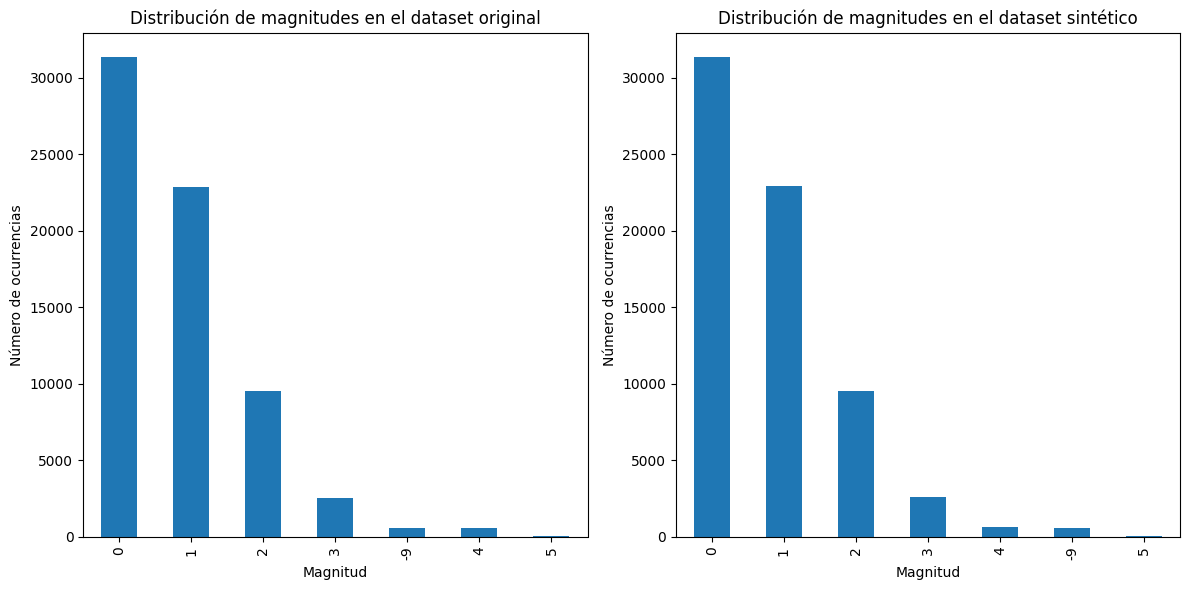

In [216]:
import matplotlib.pyplot as plt

# Crear una gráfica de barras para la columna 'mag' en el dataset original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
datos_ds['mag'].value_counts().plot(kind='bar')
plt.title('Distribución de magnitudes en el dataset original')
plt.xlabel('Magnitud')
plt.ylabel('Número de ocurrencias')

# Crear una gráfica de barras para la columna 'mag' en el dataset nuevo
plt.subplot(1, 2, 2)
datos_ds_nuevo['mag'].value_counts().plot(kind='bar')
plt.title('Distribución de magnitudes en el dataset sintético')
plt.xlabel('Magnitud')
plt.ylabel('Número de ocurrencias')

plt.tight_layout()
plt.show()


## 1 Clasificación multiclase


In [ ]:
# Verifica los valores originales de la columna 'mag'
print(datos_ds['mag'].head(10))

X = datos_ds.iloc[:, :-1].values  # Todas las columnas excepto la última
y = datos_ds.iloc[:, -1].values  # Si 'mag' es la última columna

# Asumimos que ya tienes las variables 'X' y 'y' asignadas como en el paso anterior

# Configurar las dimensiones de la capa de entrada y las etiquetas
input_layer_size = X.shape[1]  # El número de características en X (columnas)
num_labels = 5  # Puedes ajustar según la cantidad de clases que tengas en 'y'

# Reasignar valores de 'y' cambiar valores de 3 a 0:
#y[y == 3] = 0  # Este paso es opcional según el objetivo de la tarea

print(datos_ds.head())

# Imprimir las dimensiones de X e y para verificar
print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características (Input Layer Size): {input_layer_size}")
print(f"Etiquetas únicas en y: {np.unique(y)}")

# Número de muestras
m = y.size

# Verificar las primeras filas de X e y
print("Primeras filas de X:")
print(X[:5, :])

print("\nPrimeras filas de y:")
print(y[:10])



0    3
1    3
2    1
3    3
4    2
5    2
6    2
7    2
8    2
9    2
Name: mag, dtype: int64
     yr  mo  dy  st  inj  fat   slat   slon   elat   elon  len  wid  month  \
0  1950   1   3  IL    3    0  39.10 -89.30  39.12 -89.23  3.6  130      1   
1  1950   1   3  MO    3    0  38.77 -90.22  38.83 -90.03  9.5  150      1   
2  1950   1   3  OH    1    0  40.88 -84.58   0.00   0.00  0.1   10      1   
3  1950   1  13  AR    1    1  34.40 -94.37   0.00   0.00  0.6   17      1   
4  1950   1  25  IL    0    0  41.17 -87.33   0.00   0.00  0.1  100      1   

   day tipo_tornado  victimas_M tamaño_torn  mag  
0    3            B           0     pequeño    3  
1    3            B           0      grande    3  
2    3            A           0    diminuto    1  
3   13            B           1    diminuto    3  
4   25            A           0    diminuto    2  
Número de muestras: 67558
Número de características (Input Layer Size): 17
Etiquetas únicas en y: [-9  0  1  2  3  4  5]
Primeras f

In [ ]:
# Duplicar el DataFrame
datos_ds_duplicado = pd.concat([datos_ds, datos_ds], ignore_index=True)

# Verificar el tamaño del DataFrame duplicado
print(f"Número de filas después de duplicar: {datos_ds_duplicado.shape[0]}")
print(f"Número de columnas después de duplicar: {datos_ds_duplicado.shape[1]}")

# Verificar las primeras filas para asegurarse de que la duplicación se realizó correctamente
print(datos_ds_duplicado.head())

# Verificar las últimas filas
print(datos_ds_duplicado.tail())

Número de filas después de duplicar: 135116
Número de columnas después de duplicar: 18
     yr  mo  dy  st  inj  fat   slat   slon   elat   elon  len  wid  month  \
0  1950   1   3  IL    3    0  39.10 -89.30  39.12 -89.23  3.6  130      1   
1  1950   1   3  MO    3    0  38.77 -90.22  38.83 -90.03  9.5  150      1   
2  1950   1   3  OH    1    0  40.88 -84.58   0.00   0.00  0.1   10      1   
3  1950   1  13  AR    1    1  34.40 -94.37   0.00   0.00  0.6   17      1   
4  1950   1  25  IL    0    0  41.17 -87.33   0.00   0.00  0.1  100      1   

   day tipo_tornado  victimas_M tamaño_torn  mag  
0    3            B           0     pequeño    3  
1    3            B           0      grande    3  
2    3            A           0    diminuto    1  
3   13            B           1    diminuto    3  
4   25            A           0    diminuto    2  
          yr  mo  dy  st  inj  fat     slat     slon     elat     elon    len  \
135111  2021  12  30  GA    0    0  31.1703 -83.3804  31.

In [ ]:
print(X[0,:])
print(y)

[1950 1 3 'IL' 3 0 39.1 -89.3 39.12 -89.23 3.6 130 1 3]
[3 3 1 ... 1 1 1]


In [ ]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [ ]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [ ]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
# X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
X = X_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

### 1.2 Visualización de los datos

Se comenzará visualizando un subconjunto del conjunto de entrenamiento. Se selecciona al azar, 100 filas de `X` y pasa esas filas a la función` displayData`. Esta función asigna cada fila a una imagen en escala de grises de 20 píxeles por 20 píxeles y muestra las imágenes juntas.

In [ ]:
# def displayData(X, example_width=None, figsize=(10, 10)):
#     """
#     Muestra datos 2D almacenados en X en una cuadrícula apropiada.
#     """
#     # Calcula filas, columnas
#     if X.ndim == 2:
#         m, n = X.shape
#     elif X.ndim == 1:
#         n = X.size
#         m = 1
#         X = X[None]  # Promocionar a una matriz bidimensional
#     else:
#         raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

#     example_width = example_width or int(np.round(np.sqrt(n)))
#     example_height = n / example_width

#     # Calcula el numero de elementos a mostrar
#     display_rows = int(np.floor(np.sqrt(m)))
#     display_cols = int(np.ceil(m / display_rows))

#     fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
#     fig.subplots_adjust(wspace=0.025, hspace=0.025)

#     ax_array = [ax_array] if m == 1 else ax_array.ravel()

#     for i, ax in enumerate(ax_array):
#         ax.imshow(X[i].reshape(example_width, example_width, order='F'),
#                   cmap='Greys', extent=[0, 1, 0, 1])
#         ax.axis('off')

In [ ]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

# displayData(sel)

### 1.3 Vectorización de regresión logística

Se utilizará múltiples modelos de regresión logística uno contra todos para construir un clasificador de clases múltiples. Dado que hay 10 clases, deberá entrenar 10 clasificadores de regresión logística separados. Para que esta capacitación sea eficiente, es importante asegurarse de que el código esté bien vectorizado.

En esta sección, se implementará una versión vectorizada de regresión logística que no emplea ningún bucle "for".

Para probar la regresión logística vectorizada, se usara datos personalizados como se definen a continuación.

<a id="section1"></a>
#### 1.3.1 Vectorización de la funcion de costo

Se inicia escribiendo una versión vectorizada de la función de costo. En la regresión logística (no regularizada), la función de costo es

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$

Para calcular cada elemento en la suma, tenemos que calcular $h_\theta(x^{(i)})$ para cada ejemplo $i$, donde $h_\theta(x^{(i)}) = g(\theta^T x^{(i)})$ y $g(z) = \frac{1}{1+e^{-z}}$ es la funcion sigmoidea. Resulta que podemos calcular esto rápidamente para todos los ejemplos usando la multiplicación de matrices. Definamos $X$ y $\theta$ como

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Luego, de calcular el producto matricial $X\theta$, se tiene:

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$

En la última igualdad, usamos el hecho de que $a^Tb = b^Ta$ if $a$ y $b$ son vectores. Esto permite calcular los productos $\theta^T x^{(i)}$ para todos los ejemplos $i$ en una linea de codigo.

#### 1.3.2 Vectorización del gradiente

Recordemos que el gradiente del costo de regresión logística (no regularizado) es un vector donde el elemento $j^{th}$ se define como
$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

Para vectorizar esta operación sobre el conjunto de datos, se inicia escribiendo todas las derivadas parciales explícitamente para todos $\theta_j$,

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$

donde

$$  h_\theta(x) - y =
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)}
\end{bmatrix} $$

Nota $x^{(i)}$ es un vector, mientras $h_\theta\left(x^{(i)}\right) - y^{(i)}$ es un escalar(simple número).
Para comprender el último paso de la derivación, dejemos $\beta_i = (h_\theta\left(x^{(m)}\right) - y^{(m)})$ y
observar que:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix}
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & |
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

donde los valores $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

La expresión anterior nos permite calcular todas las derivadas parciales sin bucles.
Si se siente cómodo con el álgebra lineal, le recomendamos que trabaje con las multiplicaciones de matrices anteriores para convencerse de que la versión vectorizada hace los mismos cálculos.

<div class="alert alert-box alert-warning">
** Consejo de depuración: ** El código de vectorización a veces puede ser complicado. Una estrategia común para la depuración es imprimir los tamaños de las matrices con las que está trabajando usando la propiedad `shape` de las matrices` numpy`.

Por ejemplo, dada una matriz de datos $X$ de tamaño $100\veces 20$ (100 ejemplos, 20 características) y $\theta$, un vector con tamaño $20$, puede observar que `np.dot (X, theta) `es una operación de multiplicación válida, mientras que` np.dot (theta, X) `no lo es.

Además, si tiene una versión no vectorizada de su código, puede comparar la salida de su código vectorizado y el código no vectorizado para asegurarse de que produzcan las mismas salidas.</div>
<a id="lrCostFunction"></a>

In [ ]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada y
    el gradiente del costo w.r.t. a los parámetros.

    Parametros
    ----------
    theta : array_like
        Parametro theta de la regresion logistica. Vector de la forma(shape) (n, ). n es el numero de caracteristicas
        incluida la intercepcion

    X : array_like
        Dataset con la forma(shape) (m x n). m es el numero de ejemplos, y n es el numero de
        caracteristicas (incluida la intercepcion).

    y : array_like
        El conjunto de etiquetas. Un vector con la forma (shape) (m, ). m es el numero de ejemplos

    lambda_ : float
        Parametro de regularización.

    Devuelve
    -------
    J : float
        El valor calculado para la funcion de costo regularizada.

    grad : array_like
        Un vector de la forma (shape) (n, ) que es el gradiente de la
        función de costo con respecto a theta, en los valores actuales de theta..
    """
#     alpha = 0.003
#     theta = theta.copy()
    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

#     J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
#     theta = theta - (alpha / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    return J, grad
#    return J, theta

#### 1.3.3 Vectorización regularizada de la regresión logística

Una vez implementada la vectorización para la regresión logística, corresponde agregarar regularización a la función de costo.
Para la regresión logística regularizada, la función de costo se define como

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Tomar en cuenta que no debería regularizarse $\theta_0$ que se usa para el término de sesgo. En consecuencia, la derivada parcial del costo de regresión logística regularizado para $\theta_j$ se define como

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$

<div class="alert alert-box alert-warning">
** Python/numpy Consejo: ** Al implementar la vectorización para la regresión logística regularizada, a menudo es posible que solo desee sumar y actualizar ciertos elementos de $\theta$. En `numpy`, puede indexar en las matrices para acceder y actualizar solo ciertos elementos.

Por ejemplo, A [:, 3: 5] = B [:, 1: 3] reemplazará las columnas con índice 3 a 5 de A con las columnas con índice 1 a 3 de B.   
Para seleccionar columnas (o filas) hasta el final de la matriz, puede dejar el lado derecho de los dos puntos en blanco.
Por ejemplo, A [:, 2:] solo devolverá elementos desde $3^{rd}$ a las últimas columnas de $A$.Si deja el tamaño de la mano izquierda de los dos puntos en blanco, seleccionará los elementos del principio de la matriz.
Por ejemplo, A [:,: 2] selecciona las dos primeras columnas y es equivalente a A [:, 0: 2]. Además, puede utilizar índices negativos para indexar matrices desde el final.
Por lo tanto, A [:,: -1] selecciona todas las columnas de A excepto la última columna, y A [:, -5:] selecciona la columna $5^{th}$ desde el final hasta la última columna.

Por lo tanto, podría usar esto junto con las operaciones de suma y potencia ($^{**}$) para calcular la suma de solo los elementos que le interesan (por ejemplo, `np.sum (z[1:]**2)`).
</div>


<a id="section2"></a>
### 1.4 Clasificacion One-vs-all
En esta parte del ejercicio, se implementará la clasificación de uno contra todos mediante el entrenamiento de múltiples clasificadores de regresión logística regularizados, uno para cada una de las clases $K$ en nuestro conjunto de datos. En el conjunto de datos de dígitos escritos a mano, $K = 10$, pero su código debería funcionar para cualquier valor de $K$.

El argumento `y` de esta función es un vector de etiquetas de 0 a 9. Al entrenar el clasificador para la clase $k \in \{0, ..., K-1 \} $, querrá un vector K-dimensional de etiquetas $y$, donde $y_j \ in 0, 1$ indica si la instancia de entrenamiento $j ^ {th}$ pertenece a la clase $k$ $(y_j = 1)$, o si pertenece a una clase diferente $(y_j = 0)$.

Además, se utiliza `optimize.minimize` de scipy para este ejercicio.
<a id="oneVsAll"></a>

In [ ]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of
        data points, and n is the number of features. Note that we
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X.

    y : array_like
        The data labels. A vector of shape (m, ).

    num_labels : int
        Number of possible labels.

    lambda_ : float
        The logistic regularization parameter.

    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
    # algunas variables utiles
    m, n = X.shape

    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x

    return all_theta

In [ ]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)
print(all_theta.shape)

(3, 14)


In [ ]:
print(all_theta)

[[-5.9431167   1.09249539  0.62675823  1.428024    0.34141846  0.10314794
  -0.15578326 -3.05755875 -0.30526136 -1.12885295  2.07747754 -2.14176945
  -2.16418948  0.48815314]
 [-2.76714344  2.49719273  0.93966573  1.90491179 -2.81965561  0.29698877
   0.45125196  1.63676235 -0.29305502 -0.36107786 -0.13758089 -0.1271495
   1.91599118  3.10856368]
 [-3.04299407 -2.37084658 -1.20056052 -2.24760854  1.5297807   0.14407858
  -0.0378082   1.21702076  1.05250213  0.23120809 -4.38852946  1.71163052
  -0.08459958 -3.88470063]]


<a id="section3"></a>
#### 1.4.1 Prediccion One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados. La función de predicción one-vs-all seleccionará la clase para la cual el clasificador de regresión logística correspondiente genera la probabilidad más alta y devolverá la etiqueta de clase (0, 1, ..., K-1) como la predicción para el ejemplo de entrada.

In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en la matriz X.
    Tenga en cuenta que X contiene los ejemplos en filas.
    all_theta es una matriz donde la i-ésima fila es un vector theta de regresión logística entrenada para la i-ésima clase.
    Debe establecer p en un vector de valores de 0..K-1 (por ejemplo, p = [0, 2, 0, 1]
    predice clases 0, 2, 0, 1 para 4 ejemplos).

    Parametros
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.

    X : array_like
        Data points to predict their labels. This is a matrix of shape
        (m x n) where m is number of data points to predict, and n is number
        of features without the bias term. Note we add the bias term for X in
        this function.

    Devuelve
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    """

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)

    return p

Una vez que haya terminado, se llama a la función `predictOneVsAll` usando el valor aprendido de $\theta$. Debería apreciarse que la precisión del conjunto de entrenamiento es de aproximadamente 95,1% (es decir, clasifica correctamente el 95,1% de los ejemplos del conjunto de entrenamiento).

In [ ]:
print(X.shape)
pred = predictOneVsAll(all_theta, X)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y) * 100))
XPrueba = X[10:150, :].copy()
print(XPrueba.shape)
#print(np.ones((1)))
#print(XPrueba)
#p = np.zeros(1)
XPrueba = np.concatenate([np.ones((140, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p)

# displayData(X[1002:1003, :])
print(y[10:150])

(178, 13)
Precision del conjuto de entrenamiento: 100.00%
(140, 13)
(140, 14)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
